# Análise de Componentes Principais

In [1]:
# bibliotecas necessárias p/ o código
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Obter os dados

Os dados foram obtidos no [site](https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/balanco_programacao_diaria_tm/DicionarioDados_Balanco_Energetico_Programacao_Diaria.pdf) do Operador Nacional do SIstema Elétrico.

In [2]:

df = pd.read_excel('BALANCO_PROGRAMACAO_DIARIA_2023.xlsx')
df = df[ df['id_subsistema']=='SE']


data = np.array(df.iloc[:,3:])
data = StandardScaler().fit_transform(data)
data.shape

(11856, 8)

# PCA Tradicional

PCA utilizando a biblioteca do sklearn. Utilizaremos esse valor como referência para compará-lo com nosso algoritmo online.

In [3]:
pca = PCA(n_components=8)
X2D = pca.fit_transform(data)
W_ref = pca.components_.T
W_ref

array([[ 0.31394928,  0.55033384,  0.00205709, -0.35165893,  0.08932542,
        -0.0299809 ,  0.68190683,  0.03202296],
       [ 0.01357945,  0.27867317,  0.38674682,  0.66755106,  0.56624335,
        -0.07141896,  0.03480541, -0.00396571],
       [ 0.41042836,  0.15762805, -0.3644554 ,  0.44155921, -0.27760551,
         0.63326962, -0.02387547,  0.01531046],
       [ 0.39812439, -0.48270128,  0.25573152, -0.03162394,  0.08432231,
         0.09316408,  0.21478059, -0.69294824],
       [-0.31651179,  0.12845302,  0.54558295, -0.29840624,  0.01706891,
         0.69915754, -0.08559588,  0.01318333],
       [-0.13111394, -0.23391043, -0.51753964, -0.18829874,  0.72731495,
         0.2967405 ,  0.06879167,  0.05492805],
       [ 0.40398613, -0.46413679,  0.28922975, -0.0166457 ,  0.04194015,
         0.03815307,  0.14164082,  0.71705269],
       [ 0.5419609 ,  0.27384225,  0.05508555, -0.33159794,  0.23701688,
        -0.07719243, -0.67451453, -0.0345206 ]])

# PCA

In [4]:
class PCA:
    def __init__(self,data_set):
        #  Imput: data_set - matriz com os dados onde as colunas representam os atributos


        self.data_set = data_set
    
    def Offline_PCA(self,nsteps,n_components,Evaluate_periodicity):
        # Extração dos componentes principais 
        # Inputs: nteps  - número de iterações
        #         n_components - número de componentes principais a serem extraídas
        #         Evaluate_periodicity - Intervalo para o cálculo do erro por proximidade por cosseno
        # Output: W - componentes principais extraídas
        #         MSE_vector - erro calculado por proximidade por cosseno
        #         eval_vec_ind - índices que foram calculados os erros 
        X = self.data_set
        L = X.shape[0]
        N = X.shape[1]

        Y = np.zeros((n_components,L))
        W= np.random.rand(N,n_components)
        m = 0
        MSE_vector=np.ones((int(nsteps/Evaluate_periodicity),n_components))
        eval_vec_ind = []

        for k in range(nsteps):
            W_traco = np.zeros((N,n_components))
            u_sk = np.c_[np.sum(X, axis = 0) / L]
            for j in range(n_components):
                for i in range(L):
                    Y[j][i] = np.matmul(np.c_[W[:,j]].T,np.c_[X[i]])

                wj_sk = np.c_[np.sum(X*Y[j].reshape(L,1), axis = 0) / L]
                dj_sk = np.matmul(u_sk.T,np.c_[W[:,j]])
                wj_c = wj_sk - dj_sk*u_sk
                gama_un = np.linalg.norm(wj_c)
                wj_un = wj_c/gama_un
                if j==0:
                    w_ = wj_un
                    W_traco[:,j] = w_.reshape(N,)
                    W[:,j] = w_.reshape(N,)
                else:
                    Tj = np.eye(N) - np.matmul(W_traco,W_traco.T)
                    wj_d = np.matmul(Tj,wj_un)
                    w_ = wj_d / np.linalg.norm(wj_d)
                    W[:,j] = w_.reshape(N,)
                    W_traco[:,j] = w_.reshape(N,)

            if k == 1 or (k-1)%Evaluate_periodicity == 0:
                MSE_vector[m] = - np.diag(np.matmul(W_ref.T,W)) / (np.linalg.norm(W,axis=0)*np.linalg.norm(W_ref,axis=0))
                eval_vec_ind.append(k)
                m += 1
        
        return W,MSE_vector,eval_vec_ind   
    
    def Online_PCA(self, max_iteration,alpha,learning_rate,n_components,Evaluate_periodicity):
        # Extração dos componentes principais 
        # Inputs: max_iteration  - número máximo de iterações
        #         alpha - parâmetro do algoritmo
        #         learning_rate - learning rate
        #         n_components - número de componentes principais a serem extraídas
        #         Evaluate_periodicity - Intervalo para o cálculo do erro por proximidade por cosseno
        # Output: W - componentes principais extraídas
        #         MSE_vector - erro calculado por proximidade por cosseno
        #         eval_vec_ind - índices que foram calculados os erros 
        data = self.data_set
        L , N = data.shape
        mean = 0
        m=0
        lr = learning_rate
        W = np.random.normal(0,0.5,size=(N,n_components))
        MSE_vector=np.ones((int(max_iteration/Evaluate_periodicity),n_components))
        eval_vec_ind = []



        ind_pres_alg = np.array([]).astype('int')
        for _ in range(int((np.ceil(max_iteration/L)))):
            ind_pres_alg = np.append( ind_pres_alg, np.random.permutation(  range(L)  )  )
            
            
        for i in range(max_iteration):
            x = np.c_[data[ind_pres_alg[i]]]
            mean = (1-alpha) * mean + x*alpha
            x_centered = x - mean
            
            
            W_ = np.zeros((N,n_components))
            Xj = np.zeros((N,n_components))
            for j in range(n_components):
                v = np.matmul((np.eye(N) - np.matmul(W_,W_.T)),x_centered).reshape(N,)
                Xj[:,j] = v
                W_[:,j] = W[:,j]
            
            
            Tj = x * np.ones((n_components))
            Ij = Xj
            Uj = np.diag(np.matmul(W.T,Ij))
            W = W + lr*( (Tj- W*Uj ) * Uj)
        
            if i == 1 or (i-1)%Evaluate_periodicity == 0:
                MSE_vector[m] = - np.diag(np.matmul(W_ref.T,W)) / (np.linalg.norm(W,axis=0)*np.linalg.norm(W_ref,axis=0))
                eval_vec_ind.append(i)
                m += 1
        
        return W,MSE_vector,eval_vec_ind

### Proximidade por cosseno do algoritmo offline

array([[ 0.31798862, -0.54800438, -0.00318658, -0.35165889, -0.0893256 ,
         0.0299809 , -0.68190621, -0.03203616],
       [ 0.01562934, -0.27776772, -0.38732036,  0.66755133, -0.56624303,
         0.07141896, -0.03480549,  0.00396503],
       [ 0.41157613, -0.15535614,  0.36413643,  0.44155907,  0.27760573,
        -0.63326962,  0.02387576, -0.01530999],
       [ 0.39456361,  0.48614277, -0.25472912, -0.0316239 , -0.08432232,
        -0.09316408, -0.214794  ,  0.69294408],
       [-0.31555765, -0.12965234, -0.5458519 , -0.29840623, -0.01706905,
        -0.69915754,  0.08559613, -0.01318167],
       [-0.13283159,  0.23187211,  0.51801866, -0.18829839, -0.72731504,
        -0.2967405 , -0.06879061, -0.05492938],
       [ 0.40056178,  0.46769102, -0.28826546, -0.01664568, -0.04194016,
        -0.03815307, -0.14162694, -0.71705543],
       [ 0.54396048, -0.26973445, -0.05564106, -0.33159783, -0.23701704,
         0.07719243,  0.67451386,  0.03453366]])

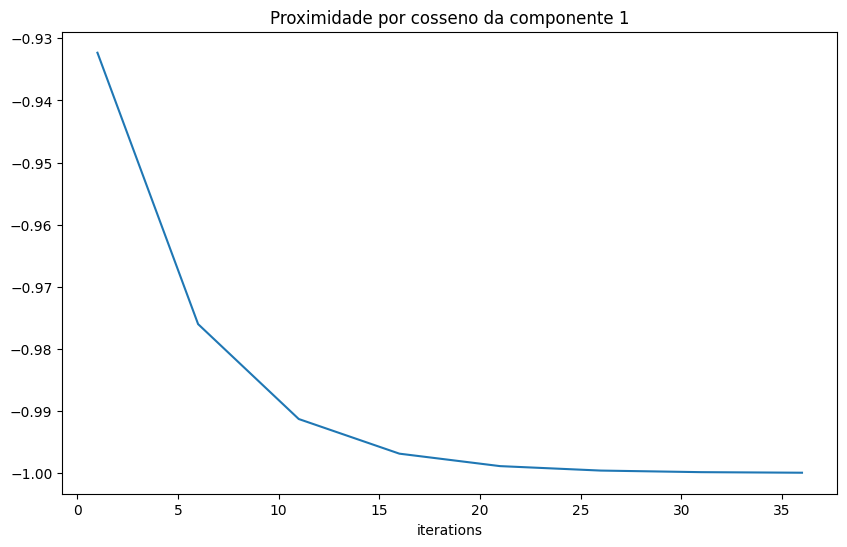

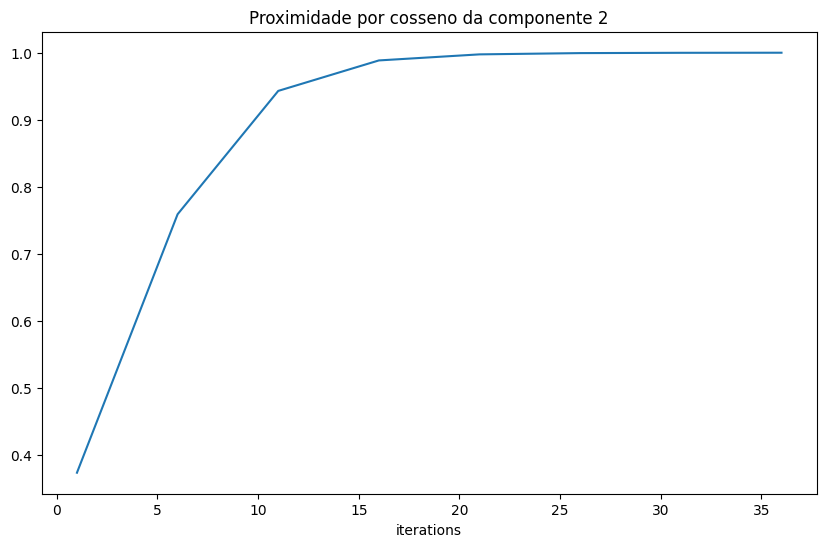

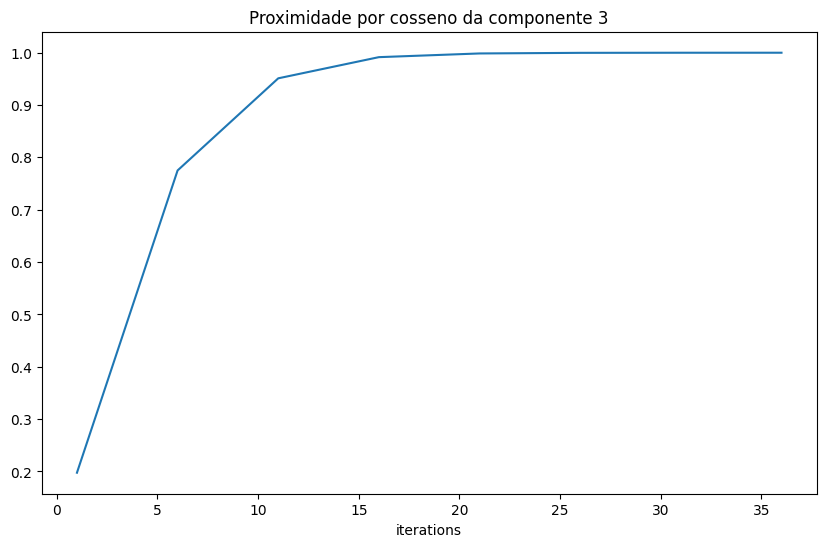

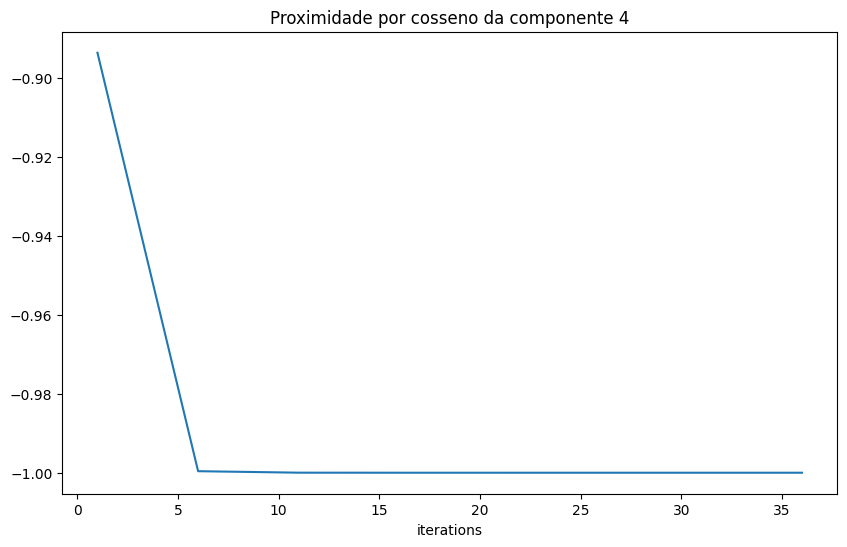

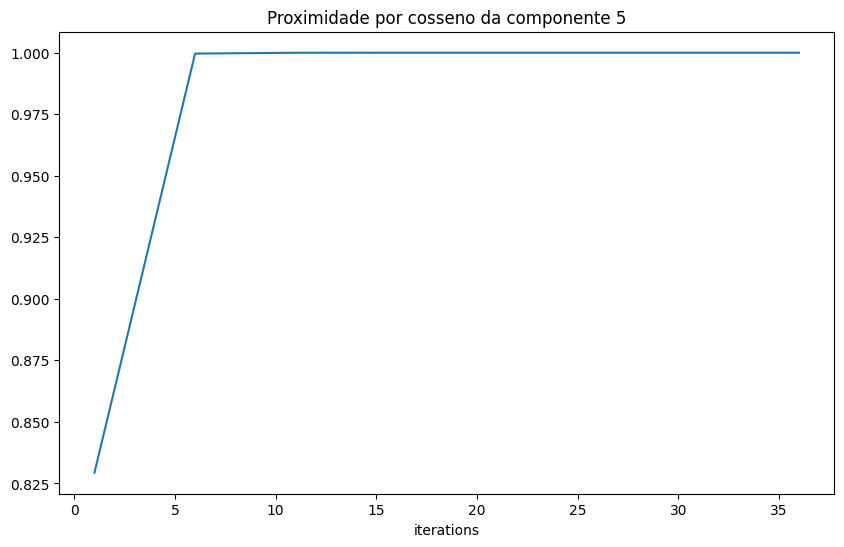

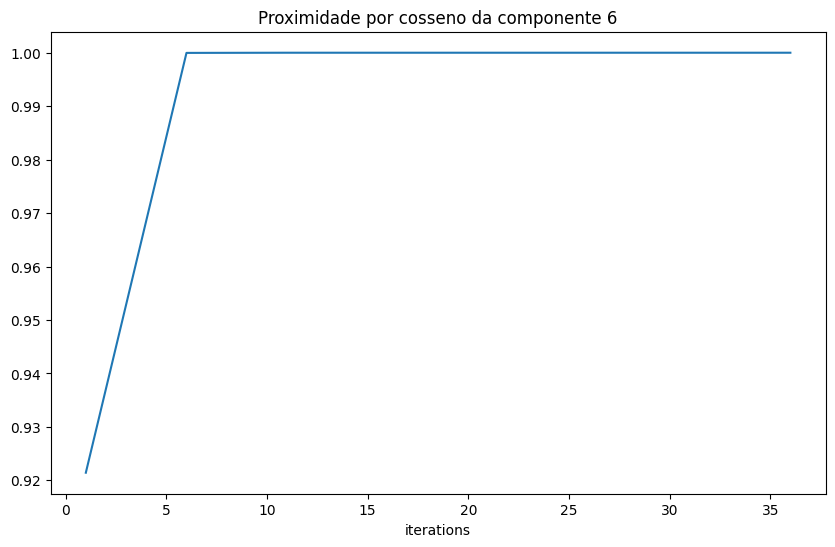

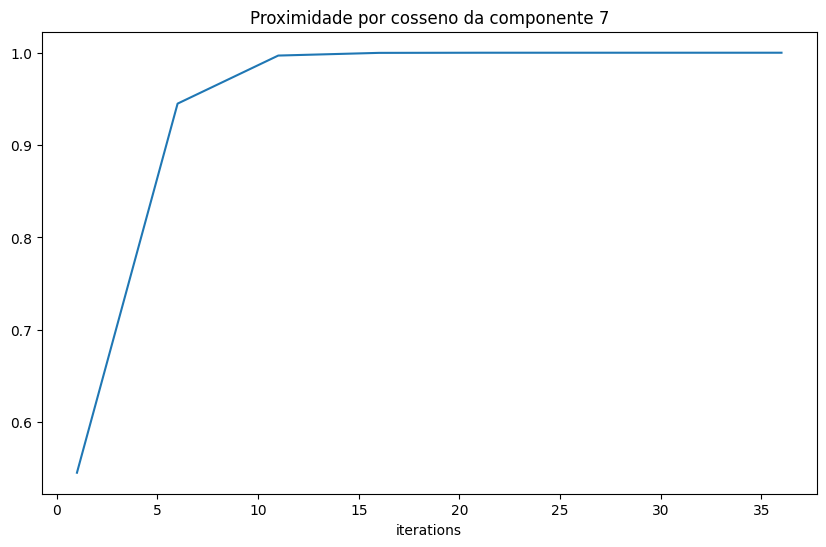

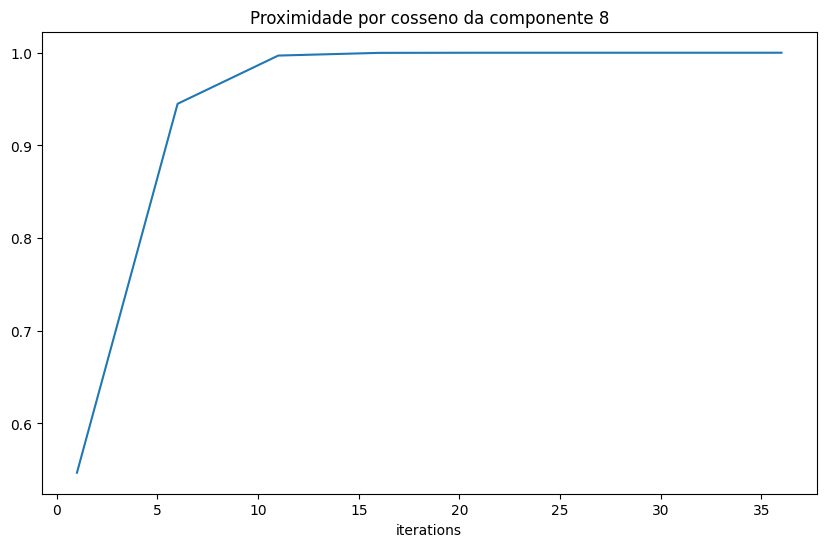

In [5]:
pca = PCA(data)
W_off, MSE_off, eval_ind_off = pca.Offline_PCA(40,8,5)
for k in range(8):
    plt.figure(figsize=(10,6))
    plt.plot(eval_ind_off,MSE_off[:,k])
    plt.title(f'Proximidade por cosseno da componente {k+1}')
    plt.xlabel('iterations')
    plt.subplots_adjust(hspace=5)
W_off

### Proximidade por cosseno do algoritmo online

array([[ 0.21607653,  0.59440709, -0.00526095, -0.34543517, -0.07935079,
        -0.0458993 , -0.68868648, -0.0447797 ],
       [-0.05312893,  0.30035721,  0.40028253,  0.68196456, -0.59149394,
        -0.07055181, -0.04417287, -0.0013434 ],
       [ 0.38933191,  0.19745612, -0.34525523,  0.44858104,  0.25804868,
         0.63485681,  0.0196676 , -0.01980577],
       [ 0.47246748, -0.41173423,  0.2669465 , -0.0185185 , -0.07358527,
         0.1018175 , -0.22149518,  0.69673249],
       [-0.34467517,  0.09698319,  0.5270905 , -0.263784  , -0.00972687,
         0.69598197,  0.07916672, -0.01049196],
       [-0.11180739, -0.28281312, -0.53520444, -0.23085302, -0.72766728,
         0.30116077, -0.06792354, -0.04824702],
       [ 0.47142056, -0.38550533,  0.30303095, -0.00092808, -0.03017155,
         0.04405814, -0.14771227, -0.71739917],
       [ 0.48395128,  0.34907849,  0.05576795, -0.31938204, -0.220283  ,
        -0.09012119,  0.66956279,  0.02360654]])

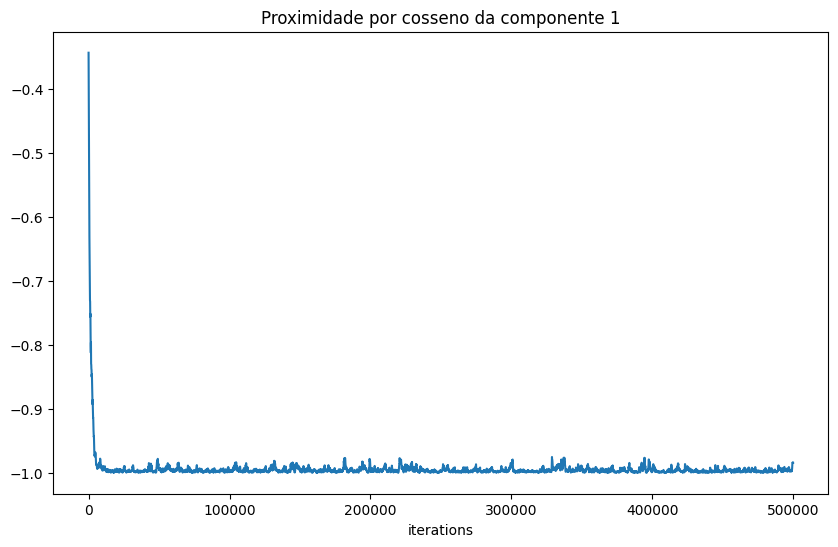

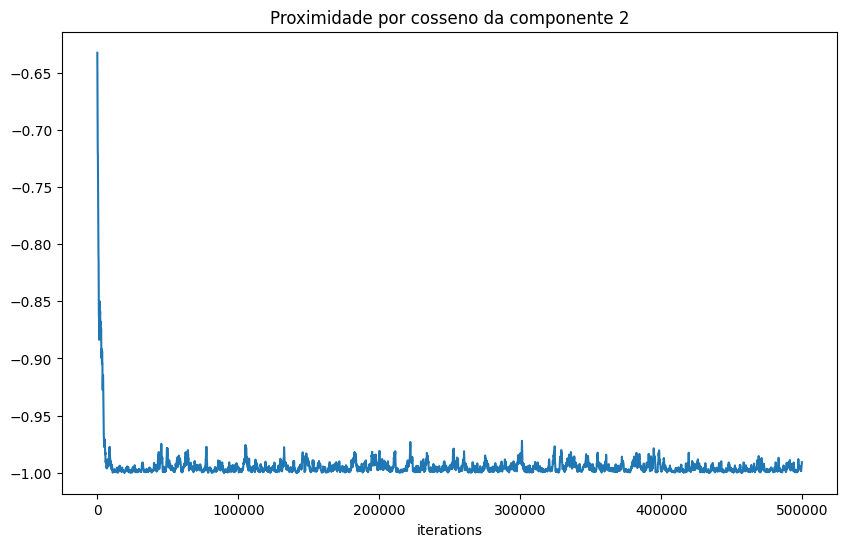

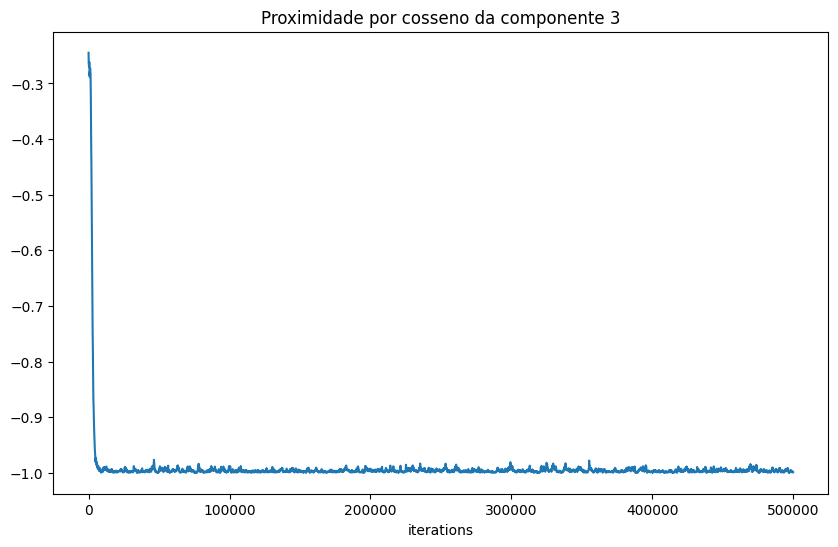

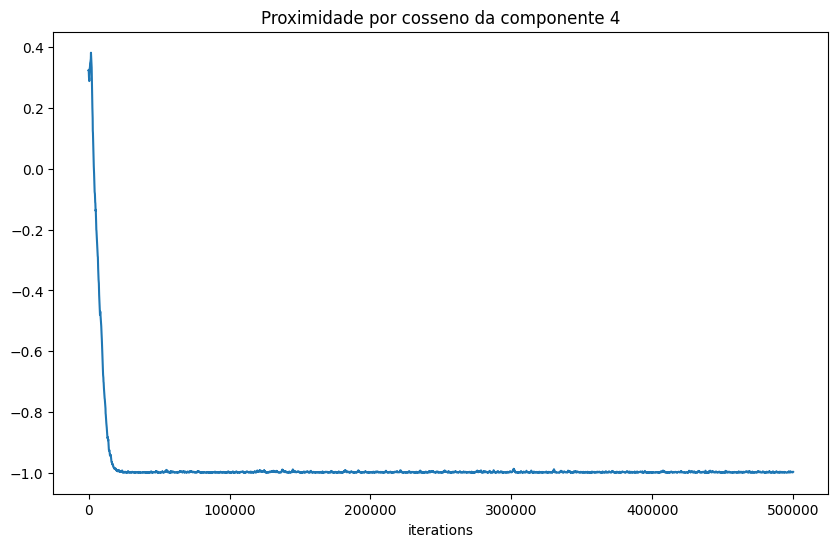

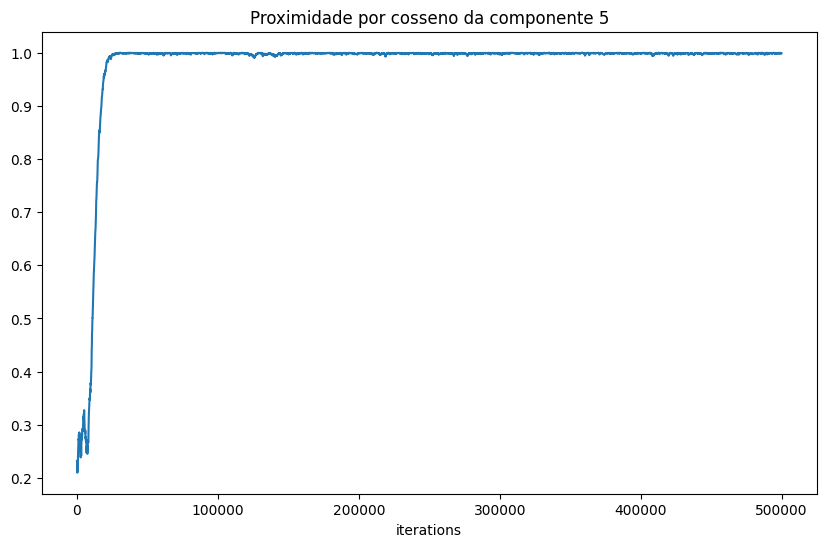

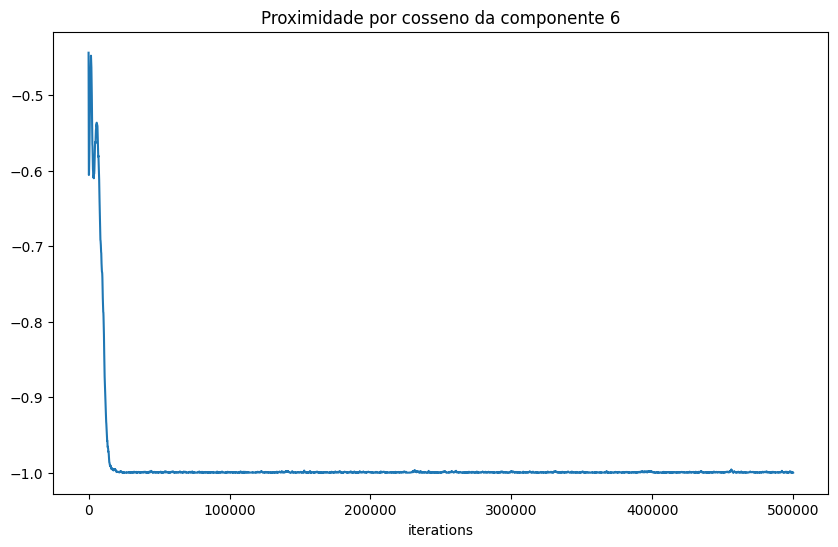

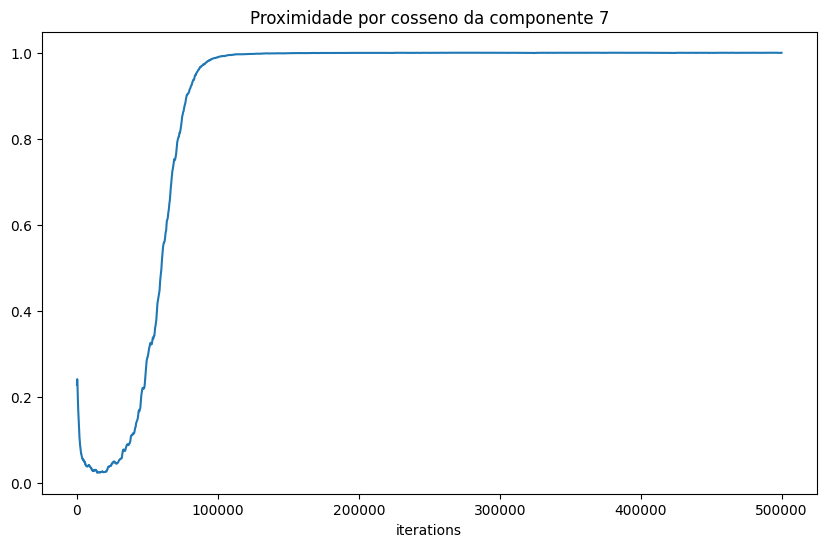

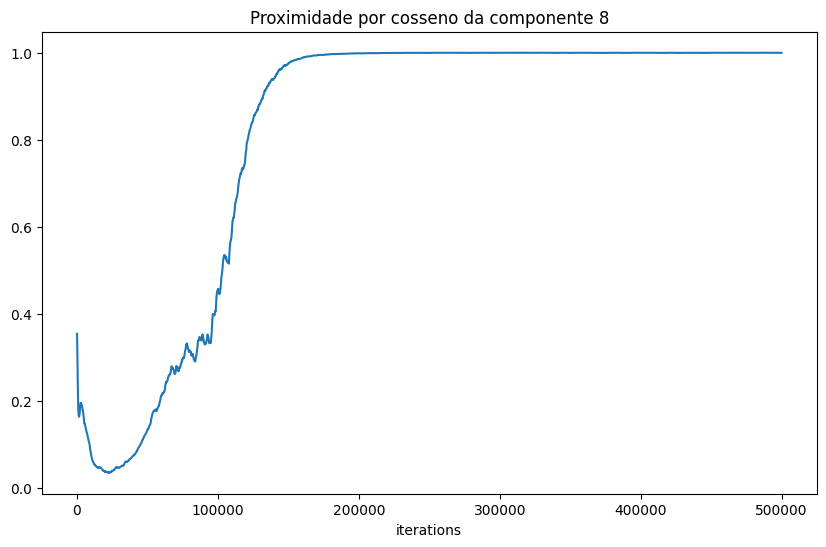

In [6]:
W_on, MSE_on, eval_ind_on = pca.Online_PCA(max_iteration=500000,alpha=0.02,learning_rate=0.001,n_components=8,Evaluate_periodicity=100)
for k in range(8):
    plt.figure(figsize=(10,6))
    plt.plot(eval_ind_on,MSE_on[:,k])
    plt.title(f'Proximidade por cosseno da componente {k+1}')
    plt.xlabel('iterations')
    plt.subplots_adjust(hspace=5)
W_on